In [2]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

C:\Users\DELL\AppData\Local\Temp\ipykernel_15296\4144572755.py:14: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


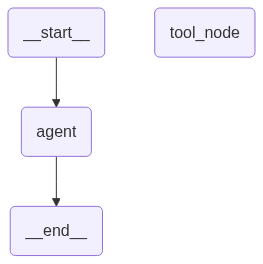

In [3]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [4]:

search_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='4f32299e-c7db-4747-bdfc-47a7fc81346c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'm412e9320', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.03712473, 'prompt_time': 0.016959567, 'queue_time': 0.09112798400000001, 'total_time': 0.054084297}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5ecb20e1-a64d-46c4-9d84-9d041565829f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'm412e9320', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306}),
  ToolMessage(conten

Shared Schema 

In [5]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})
result  

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='b0971b29-853b-4daa-ad61-979f2783055f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ehs3hm495', 'function': {'arguments': '{"query":"Current weather in Chennai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 569, 'total_tokens': 590, 'completion_time': 0.032113931, 'prompt_time': 0.037326797, 'queue_time': -0.07116528999999999, 'total_time': 0.069440728}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cec7df03-0468-48a9-bf35-f1f0e896577d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Current weather in Chennai'}, 'id': 'ehs3hm495', 'type': 'tool_call'}], usage_metadata={'input_tokens': 569, 'output_tokens': 21, 'total_tokens': 590}),
  ToolMe

Different Schema

In [6]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    
    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)
    
    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "How is the weather in Chennai?", "response": ""})
print(result)

{'query': 'How is the weather in Chennai?', 'response': 'The weather in Chennai today is warm and humid with a high chance of rain. The forecast for the week indicates that it will be partly cloudy with thundery outbreaks possible. The average weather in Chennai in July is characterized by patchy rain possible, overcast, light drizzle, and light rain showers.'}
